In [18]:
from imp import reload
import cProfile

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import cca
import gp

reload(cca)
reload(gp)

<module 'gp' from '/home/davidclark/Projects/ComplexityComponentsAnalysis/gp.py'>

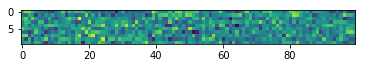

In [24]:
#Make Kernel
K = gp.gen_kernel("squared_exp", spatial_scale=2.0, temporal_scale=5.0)

#Generate 10,000 time-steps in total
T = 500
num_to_concat = 20

#10-dimensional ambient space
N = 10

#3-dimensional GP embedding
d = 3

#Noise with variance 1
noise_sigma = 1
noise_cov = sigma**1 * np.eye(N)

#Generate data 
X = gp.embed_gp(T, N, d, K, noise_cov, num_to_concat=num_to_concat)
plt.imshow(X[:100, :].T)

In [25]:
T_pi = 20
pi_proj_vals = np.zeros(N)

for opt_dim in range(1, N+1):
    V_opt = cca.run_cca(X, T_pi, opt_dim, init="random_ortho", method="BFGS")
    pi_proj = cca.calc_pi(np.dot(X, V_opt), T_pi)
    print(pi_proj)
    pi_proj_vals[opt_dim-1] = pi_proj
    
    
    

1.2734542996176879
1.815426441071768
2.01469563756144
2.21875130541351
2.350832252540884
2.4767153201591796
2.6019005054791178
2.6493269256705423
2.631363019544187
2.5316979689411374


Text(0.5,1,'PI in optimal subspaces of increasing dimensionality')

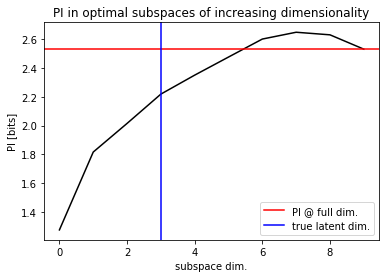

In [33]:
plt.plot(pi_proj_vals, c="black")
plt.axhline(cca.calc_pi(X, T_pi), label="PI @ full dim.", c="red")
plt.axvline(d, label="true latent dim.", c="blue")
plt.xlabel("subspace dim.")
plt.ylabel("PI [bits]")
plt.legend()
plt.title("PI in optimal subspaces of increasing dimensionality")